This notebook attempts to respond to the reviewers' comments about the kappa stuff for the classifiers.

In [14]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Add src/util to path and import modules from files there
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import FileIO as fio
from util import collapse_taxonomic_contents_df, prep_classifier, cv_and_roc

In [2]:
random_state = 12345

datadir = '../../data/clean_tables/'
dataset = 'ibd_papa'

df, meta = fio.read_dataset_files(dataset, datadir)
df.shape

(91, 2742)

In [3]:
classes_list = fio.get_classes(meta, dataset)
H_smpls, dis_smpls = fio.get_samples(meta, classes_list)

rf, X, Y = prep_classifier(df, H_smpls, dis_smpls, random_state)
results = cv_and_roc(rf, X, Y, random_state=random_state)

In [4]:
results.keys()

['y_true',
 'y_prob',
 'mean_tpr',
 'mean_fpr',
 'test_fold',
 'kappa_scores',
 'conf_mat',
 'kappas',
 'fisher_p',
 'roc_auc']

In [5]:
results['kappas']

[0.37704918032786866,
 0.15094339622641509,
 0.0,
 0.26530612244897994,
 0.33766233766233772]

In [6]:
results['kappa_scores']

[0.37704918032786866,
 0.15094339622641509,
 0.0,
 0.26530612244897994,
 0.33766233766233772]

In [43]:
dfdict = fio.read_dfdict_data(datadir)

 Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller liv_zhang ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang art_scher crc_chen ob_turnbaugh hiv_dinh noncdi_schubert ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [44]:
k_lst = []
for dataset in dfdict.keys():
    print(dataset),
    df = dfdict[dataset]['df']
    meta = dfdict[dataset]['meta']

    # Prepare OTU table: collapse to genus, keep only core (if required)
    df = collapse_taxonomic_contents_df(df,'genus')

    classes_list = fio.get_classes(meta, dataset)
    H_smpls, dis_smpls = fio.get_samples(meta, classes_list)

    rf, X, Y = prep_classifier(df, H_smpls, dis_smpls, random_state=random_state)
    results = cv_and_roc(rf, X, Y, random_state=random_state)

    tmp = pd.DataFrame(columns=['dataset', 'kappa'])
    tmp['kappa'] = results['kappas']
    tmp['dataset'] = dataset
    k_lst.append(tmp)
    dfdict[dataset].update(results)

art_scher cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh crc_chen asd_son crc_zeller liv_zhang ob_turnbaugh ibd_papa hiv_dinh ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_willing ibd_morgan ibd_gevers nash_wong ob_zupancic nash_zhu cdi_vincent ob_ross t1d_mejialeon noncdi_schubert asd_kang ob_goodrich


In [45]:
k_df = pd.concat(k_lst)
k_df.head()

,dataset,kappa
0,art_scher,0.000000
1,art_scher,0.000000
2,art_scher,0.000000
3,art_scher,0.000000
4,art_scher,-0.149254


In [46]:
fname = '../../data/analysis_results/rf_results.txt'
rfresults = pd.read_csv(fname, sep='\t')

(0.5, 1)

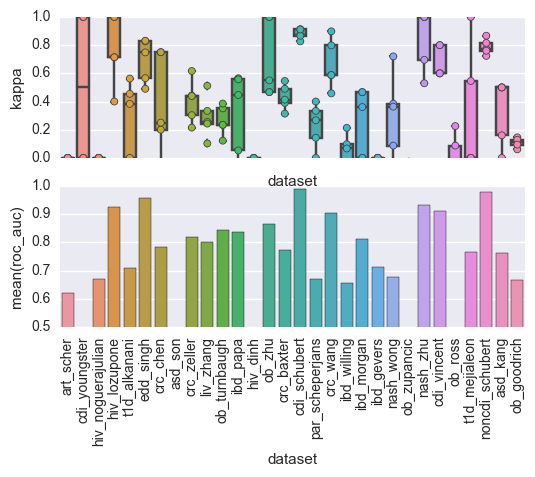

In [47]:
fig, ax = plt.subplots(2, 1)
sns.boxplot(data=k_df, x='dataset', y='kappa', ax=ax[0])
sns.stripplot(data=k_df, x='dataset', y='kappa', ax=ax[0], linewidth=0.6)#, ci=None)
_ = ax[0].set_xticklabels([])
ax[0].set_ylim([0, 1])

sns.barplot(data=rfresults[['dataset', 'roc_auc']].drop_duplicates(), x='dataset', y='roc_auc', ax=ax[1])
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_ylim([0.5, 1])

In [48]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
# Is the average kappa value from each of the five folds the same as the overall one from the probabilities?
for dataset in dfdict:
    print('{}, avg: {:.3f}, total: {:.3f}'.format(
            dataset, 
            np.mean(dfdict[dataset]['kappa_scores']), 
            cohen_kappa_score(dfdict[dataset]['y_true'], dfdict[dataset]['y_prob'] > 0.5)))

art_scher, avg: -0.030, total: -0.034
cdi_youngster, avg: nan, total: 0.623
hiv_noguerajulian, avg: 0.000, total: 0.000
hiv_lozupone, avg: 0.766, total: 0.759
t1d_alkanani, avg: 0.262, total: 0.267
edd_singh, avg: 0.693, total: 0.699
crc_chen, avg: 0.347, total: 0.348
asd_son, avg: -0.165, total: -0.165
crc_zeller, avg: 0.403, total: 0.414
liv_zhang, avg: 0.289, total: 0.294
ob_turnbaugh, avg: 0.265, total: 0.278
ibd_papa, avg: 0.303, total: 0.342
hiv_dinh, avg: -0.224, total: -0.263
ob_zhu, avg: 0.697, total: 0.693
crc_baxter, avg: 0.431, total: 0.432
cdi_schubert, avg: 0.878, total: 0.878
par_scheperjans, avg: 0.229, total: 0.230
crc_wang, avg: 0.666, total: 0.669
ibd_willing, avg: 0.025, total: 0.026
ibd_morgan, avg: 0.259, total: 0.255
ibd_gevers, avg: 0.000, total: 0.000
nash_wong, avg: 0.292, total: 0.280
ob_zupancic, avg: -0.106, total: -0.105
nash_zhu, avg: 0.845, total: 0.839
cdi_vincent, avg: 0.680, total: 0.680
ob_ross, avg: -0.069, total: -0.068
t1d_mejialeon, avg: 0.309, t

In [40]:
results.keys()

['y_true',
 'y_prob',
 'mean_tpr',
 'mean_fpr',
 'test_fold',
 'kappa_scores',
 'conf_mat',
 'kappas',
 'fisher_p',
 'roc_auc']